In [ ]:
# This file is kind of slow, I don't recomend using it.

In [2]:
# Make Scottish Local Authority Area Shapefiles
#From data published by [NRS](https://www.nrscotland.gov.uk/statistics-and-data/geography/our-products/scottish-postcode-directory/2020-2), I want to make shape files that represent each local authority area, as I cannot seem to find a publically available dataset that contains these.

#The following can be straightforwardly modified to give the desired level of granularity down to the 4th post code digit, to do this index over the district or sector columns in allData, rather than council number.

#Import libraries to use

import geopandas as gpd
from matplotlib import pyplot as plt
from shapely.geometry import Polygon, LinearRing, shape
from shapely.ops import cascaded_union

allData = gpd.read_file("PC_Cut_20_2.shp")
allData = allData.drop(["OBJECTID_1","Shape_Leng","Shape_Area", "Postcode", "District", "Sector", "DoIntro", "OA11", "DZ11", "EW19"], axis=1)

print(allData.head(2))

#The postcode-specific shapefiles are too granular for the data I have. I want to merge the polygons into local authority areas.

#Make a list of LA codes:

LAN = allData.drop_duplicates('Council').Council.reset_index().drop("index", axis = 1)

# sort post codes into local authority areas, make a polygon that represents each LA area
newdata = gpd.GeoDataFrame()
newdata['geometry'] = None
ind = 0
for councilNo in LAN.Council:
    polygons = []
    for item in allData[allData["Council"] == councilNo].geometry:
        polygons.append(item)
    u = cascaded_union(polygons)
    newdata.loc[ind, 'geometry'] = u
    ind +=1

# label each row with the local authority area number
ind = 0
for item in LAN.Council:
    newdata.loc[ind, 'LAN'] = item
    ind +=1

# name the output file
outfp = "LAAreas.shp"

# Write the data into that Shapefile
newdata.to_file(outfp)

     Council                                           geometry
0  S12000033  POLYGON ((394357.032 806577.664, 394331.680 80...
1  S12000033  POLYGON ((394385.000 806565.000, 394412.000 80...


         LAN                                           geometry
0  S12000033  MULTIPOLYGON (((382317.275 798730.809, 382302....
       Date         CA            CAName  NewPositive  TotalCases  \
0  20210113  S12000005  Clackmannanshire           18        1339   

   CrudeRatePositive  NewDeaths  TotalDeaths  CrudeRateDeaths  TotalNegative  \
0         2597.98215          0           49        95.071789          15331   

   CrudeRateNegative  
0       29745.828483  
         LAN                                           geometry      Date  \
0  S12000033  MULTIPOLYGON (((382317.275 798730.809, 382302....  20210113   
1  S12000034  MULTIPOLYGON (((375338.002 764464.197, 375299....  20210113   

          CAName  NewPositive  TotalCases  CrudeRatePositive  NewDeaths  \
0  Aberdeen City           65        5299        2317.313159          3   
1  Aberdeenshire           80        4187        1602.924850          2   

   TotalDeaths  CrudeRateDeaths  TotalNegative  CrudeRateNegative  


<ipython-input-8-d44da5fe0ef1>:28: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  areaPopn = pd.read_csv("councilAreaPopn.txt", delimiter = "  ").drop(["Ind", "Electors"], axis = 1)


         LAN                                           geometry      Date  \
0  S12000033  MULTIPOLYGON (((382317.275 798730.809, 382302....  20210113   
1  S12000034  MULTIPOLYGON (((375338.002 764464.197, 375299....  20210113   
2  S12000041  MULTIPOLYGON (((332300.432 731128.778, 332286....  20210113   
3  S12000020  MULTIPOLYGON (((318734.660 810885.610, 318687....  20210113   
4  S12000017  MULTIPOLYGON (((172564.499 740754.001, 172574....  20210113   

          CAName  NewPositive  TotalCases  CrudeRatePositive  NewDeaths  \
0  Aberdeen City           65        5299        2317.313159          3   
1  Aberdeenshire           80        4187        1602.924850          2   
2          Angus           29        2103        1809.810671          1   
3          Moray           12         673         702.358589          0   
4       Highland           49        2116         897.256498          1   

   TotalDeaths  CrudeRateDeaths  TotalNegative  CrudeRateNegative  Population  \
0    

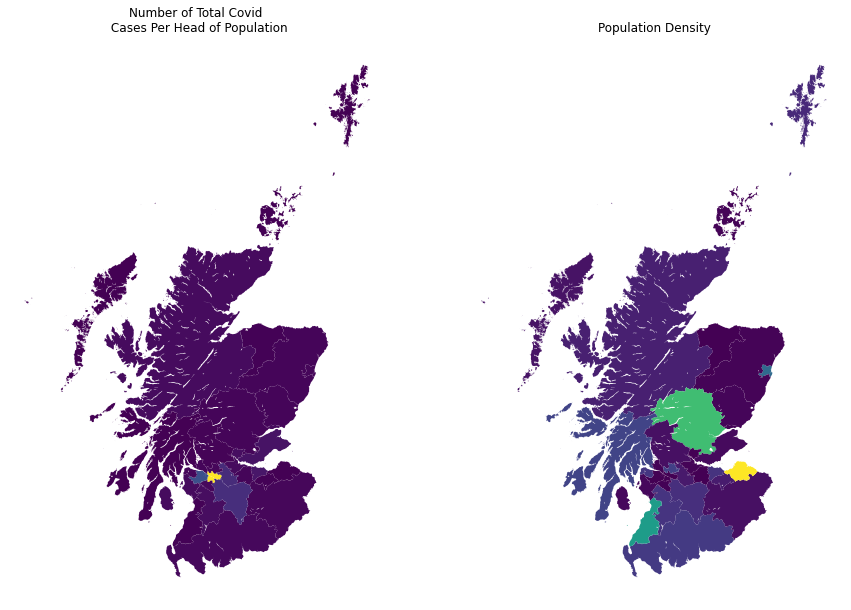

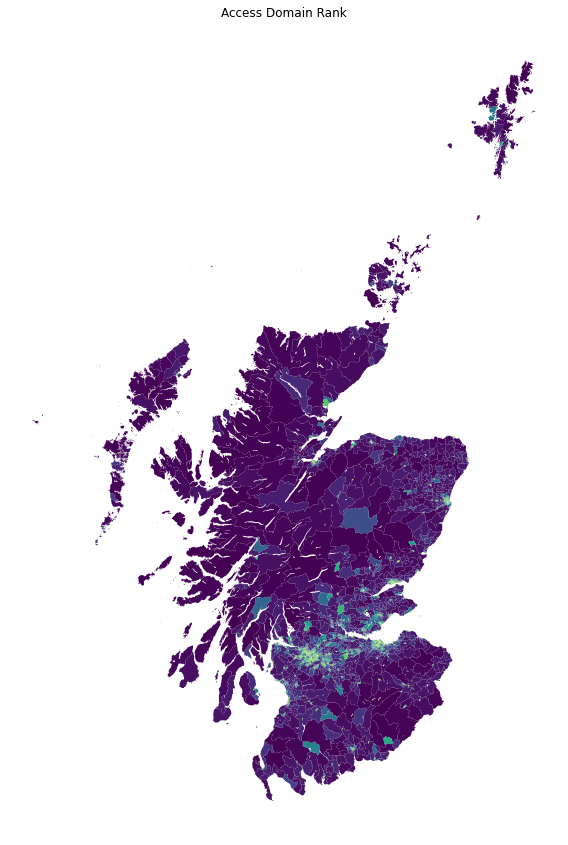

In [8]:
#Is population density a good predictor of coronavirus infections in Scotland?
#If not, what is?

#Import libraries to use

import pandas as pd

LAShape = gpd.read_file("LAAreas.shp")

covidByLA = pd.read_csv("total_cases_by_la_20210113.csv")

#Inspect the data, make sure it looks right.
#LA Shape should be a council number and multipolygon;
#covidByLA is a date, council number and name, then mortality statistics.

print(LAShape.head(1))

print(covidByLA.head(1))

#In the shape file loaded above, each council has a unique 8 digit code with a leading S: a CA number. There are 32 local authority areas, and we can generally map the first two digits of the postcode to the LA. As seen above, the covid deaths by local authority also have CA numbers.

#Left join the spatial data with the death data:

allData = LAShape.merge(covidByLA.rename({'CA': 'Council_r'}, axis=1),
               left_on='LAN', right_on='Council_r', how='left').drop('Council_r', axis = 1)
print(allData.head(2))

areaPopn = pd.read_csv("councilAreaPopn.txt", delimiter = "  ").drop(["Ind", "Electors"], axis = 1)
areaPopn = areaPopn.sort_values(by="CAName").reset_index().rename({'CAName': 'CAName_r'}, axis=1)
areaPopn = areaPopn.drop("index", axis = 1)

#print(areaPopn.head(5))

popn = areaPopn.Population
density = areaPopn.Density
area = areaPopn.Area

# add the population and density columns to the larger dataframe
allData["Population"] = popn
allData["Density"] = density
allData["Area"] = area

print(allData.head(5))

allData["TotalCasesNornPopn"] = allData["TotalCases"]/allData["Population"]

fig = plt.figure(figsize=(15,15))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1 = allData.plot(column = "TotalCasesNornPopn", ax = ax1)
ax1.set_axis_off()
ax1.title.set_text("Number of Total Covid \n Cases Per Head of Population")
ax2.title.set_text("Population Density")
ax2 = allData.plot(column = "Density", ax = ax2)
ax2.set_axis_off()
plt.show()
fig.savefig("totalcasesvsdensity.png", dpi=300)

# load simd spatial and socio-economic data
SIMDspatial = gpd.read_file("sc_dz_11.shp").drop(["Name", "TotPop2011", "StdAreaHa", "Shape_Leng"], axis = 1)
SIMDcsv = pd.read_csv("simd2020_withinds.csv")

# rename column to left join
SIMDspatial = SIMDspatial.rename({'DataZone': 'Data_Zone_r'}, axis=1);

# left join on zone number and remove extraneous columns
SIMDmerged = SIMDcsv.merge(SIMDspatial,left_on='Data_Zone', right_on='Data_Zone_r', how='left')\
.drop(['Data_Zone_r', "Intermediate_Zone", "SIMD2020v2_Rank", \
    "SIMD2020v2_Vigintile", "SIMD_2020v2_Percentile", "SIMD2020v2_Quintile"], axis = 1)

# plotting from SIMD isn't working, so add column to plot from to spatial data dataframe
Access_Domain_Rank = SIMDmerged["SIMD2020_Access_Domain_Rank"]
SIMDspatial["Access_Domain_Rank"] = Access_Domain_Rank

# make the plot

fig = plt.figure(figsize=(15,15))
ax1 = fig.add_subplot(111)
#ax2 = fig.add_subplot(122)
ax1 = SIMDspatial.plot(column = "Access_Domain_Rank", ax = ax1)
ax1.set_axis_off()
ax1.title.set_text("Access Domain Rank")
#ax2.title.set_text("Population Density")
#ax2 = allData.plot(column = "Density", ax = ax2)
#ax2.set_axis_off()
plt.show()
fig.savefig("SIMD.png", dpi=300)

